In [27]:
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

#######################
#       imports       #
#######################
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
import xgboost as xgb

sns.set_style("whitegrid")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/thibaud/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'pylab', 'randint']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [28]:
from importlib import reload
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)
import matplotlib.cm as cm
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sqlalchemy import create_engine
import pandas as pd
from sklearn.model_selection import train_test_split

In [29]:
df = pd.read_csv('Spotify Data/data-clean.csv')

#drop track, artist, track_id 
df = df.drop(['track', 'artist', 'track_id'], axis=1)

In [30]:
df.columns = map(str.lower, df.columns)
df['track_seconds'] = df['duration_ms'] / 1000
df.columns
df.shape

(40686, 17)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import learning_curve


In [32]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=(7,5))
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="mako") #mako
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.savefig("xg_confmatrix.png")
    plt.show()
    return fig


In [33]:
#Function used to plot the learning curve, roc curve, and confusing matrix for the given model
def plot_model(model, X, y , X2, y2,threshold=0.5):
    model.fit(X, y)
    y_predict = model.predict(X)
    #y_predictprob = model.predict_proba(X)[:, 1]
    
    y_predictprob = (model.predict_proba(X)[:, 1] >=threshold).astype('int')

    LR_acc = np.round(np.mean(cross_val_score(model, X, y, scoring = 'accuracy', cv = 5)), 5)
    LR_f1 = np.round(np.mean(cross_val_score(model, X, y, scoring = 'f1', cv = 5)), 5)
    LR_prec = np.round(np.mean(cross_val_score(model, X, y, scoring = 'precision', cv = 5)), 5)
    LR_recall = np.round(np.mean(cross_val_score(model, X, y, scoring = 'recall', cv = 5)), 5)
    print(f'The base LR accuracy is: {LR_acc}')
    print(f'The base LR f1 is: {LR_f1}')
    print(f'The base LR precision is: {LR_prec}')
    print(f'The base LR recall is: {LR_recall}')

    #print("train : all metrics:", metrics.classification_report(y,y_predictprob))

    print("Precision: {:6.4f},   Recall: {:6.4f}, Accuracy: {:6.4f}".format(precision_score(y, y_predictprob),
                                                        recall_score(y, y_predictprob) ,
                                                        accuracy_score(y,y_predictprob)))
    
    
    m, train_err, test_err = learning_curve(model, X, y, cv = 5, scoring = 'f1', random_state = 42)
    m_trainerr = np.mean(train_err, axis = 1)
    m_testerr = np.mean(test_err, axis = 1)

    print("train error", m_trainerr.mean(), "test error", m_testerr.mean())
    print("y pred proba ",y_predictprob)
    
    
    # try
    
    ns2_probs = [0 for _ in range(len(y2))]
    y2_predict = model.predict(X2)
    y2_predictprobs = model.predict_proba(X2)[:, 1]
    y2_predictprob = (model.predict_proba(X2)[:, 1]>=threshold).astype('int')
    
    #print("test : all metrics: ", metrics.classification_report(y2,y2_predictprob))    
    print("Precision: {:6.4f},   Recall: {:6.4f}, Accuracy: {:6.4f}, f1: {:6.4f}".format(precision_score(y2, y2_predictprob),
                                                        recall_score(y2, y2_predictprob) ,
                                                        accuracy_score(y2,y2_predictprob),
                                                        f1_score(y2,y2_predictprob)))
    
    
    '''
    connect predictions with outputs for sample probablity
    '''
    global y_pred_prob_df 
    global y_pred_df
    y3_predictprob = (model.predict_proba(X2)[:, 1]) 
    
#     print("X inputs: ", X2[:10], type(X2))
#     print("y predicted prob: ", y3_predictprob[:10], type(y3_predictprob))
#     print("y predicted outcomes: ", y2_predictprob[:10], type(y2_predictprob))
#     print("y actuals: ",y2[:10] , type(y2))
    
    y_pred_prob_df = pd.DataFrame(y3_predictprob,columns=['y_pred_prob'])
    y_pred_df = pd.DataFrame(y2_predictprob,columns=['y_pred'])    
    
    '''
    change array and series to df
    '''
    
    fpr, tpr, thr = roc_curve(y2, y2_predictprobs)
    
    ns2_auc = roc_auc_score(y2, ns2_probs)
    ns2_fpr, ns2_tpr, _ = roc_curve(y2, ns2_probs)

#     optimal_idx = np.argmax(tpr - fpr)
#     optimal_threshold = thresholds[optimal_idx]
#     print("optimal idx", optimal_idx, "optimal threshold", optimal_threshold)
    
    plt.rcParams.update({'figure.figsize': (7, 5)})
#     plt.subplot(1,2,1)
#     plt.plot(m, m_trainerr, 'k', m, m_testerr, 'r')
#     plt.xlabel('Number of Samples', fontsize = 10)
#     plt.ylabel('F1', fontsize = 10)
#     plt.legend(['Training Error', 'Test Error'])
    #plt.subplot(1,2,2)
    
    plt.plot(fpr, tpr)
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {np.round(roc_auc_score(y2, y2_predictprobs), 4)}");

    print(f'AUC: {np.round(roc_auc_score(y2, y2_predictprobs), 4)}')
    
    pyplot.plot(ns2_fpr, ns2_tpr, linestyle='--', label='No Skill')
    plt.tight_layout()
    plt.savefig("xg_aucroc.pdf")
    
    
    conf_mat = confusion_matrix(y2, y2_predictprob)
    cm = print_confusion_matrix(conf_mat, ['not a hit', 'is a hit'])
    
    return y_pred_prob_df 
    return y_pred_df


In [43]:
# Establishing X and y
y = df['target']
X = df.drop(columns = ['target','duration_ms', 'mode', 'key'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

X2_train, X2_test,  y2_train,y2_test = train_test_split(X_train,y_train, test_size = 0.25, random_state = 42)

In [44]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import pylab
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import itertools

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40686 entries, 0 to 40685
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      40686 non-null  float64
 1   energy            40686 non-null  float64
 2   loudness          40686 non-null  float64
 3   speechiness       40686 non-null  float64
 4   acousticness      40686 non-null  float64
 5   instrumentalness  40686 non-null  float64
 6   liveness          40686 non-null  float64
 7   valence           40686 non-null  float64
 8   tempo             40686 non-null  float64
 9   time_signature    40686 non-null  int64  
 10  chorus_hit        40686 non-null  float64
 11  sections          40686 non-null  int64  
 12  track_seconds     40686 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 4.0 MB


In [45]:
xgb_base = GradientBoostingClassifier()
plot_model(xgb_base, X2_train, y2_train, X2_test, y2_test)

The base LR accuracy is: 0.76998
The base LR f1 is: 0.78488
The base LR precision is: 0.73258
The base LR recall is: 0.84527
Precision: 0.7428,   Recall: 0.8572, Accuracy: 0.7818
train error 0.8163909448645181 test error 0.7829956623026343
y pred proba  [1 1 0 ... 1 1 0]
Precision: 0.7274,   Recall: 0.8531, Accuracy: 0.7713, f1: 0.7852
AUC: 0.8507


/var/folders/3h/r2hbd12s1r9ccvfmt_h9r3pm0000gn/T/ipykernel_7743/2678545404.py:38: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,y_pred_prob
0,0.704912
1,0.519810
2,0.064422
3,0.704496
4,0.415812
...,...
8132,0.504306
8133,0.871610
8134,0.713410
8135,0.867353


In [46]:
# GridSearchCV For Gradient Boosting
grad = GradientBoostingClassifier()
grad_param = {'n_estimators':[100],
              'max_depth':[3,5],
              #'max_features': [6,10],
              #'min_samples_split': [None], 
              #'min_samples_leaf':[3,10],
              'learning_rate': [0.1] #0.0001, 0.001, 0.01, 
             }

grad_grid = GridSearchCV(grad, param_grid=grad_param, cv=3, scoring='f1', verbose=True, n_jobs=-1)

In [47]:
xgb1 = grad_grid.fit(X2_train,y2_train)

grad_ypred = grad_grid.predict(X2_test)

grad_yproba = grad_grid.predict_proba(X2_test)[:,1]

fpr_grad, tpr_grad, _ = roc_curve(y2_test, grad_yproba)

print('best score: ',xgb1.best_score_)
print('best params: ',xgb1.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
best score:  0.786196487439943
best params:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [48]:
xgb2=GradientBoostingClassifier(                   
                   max_depth=3, 
                   max_features=4,
                   max_leaf_nodes=None,                   
                   #min_samples_leaf=10,
                   n_estimators=100,
                   learning_rate=0.1)

In [49]:
xgb2b = xgb2.fit(X2_train,y2_train)

grad_ypred = xgb2.predict(X2_test)

grad_yproba = xgb2.predict_proba(X2_test)[:,1]

fpr_grad, tpr_grad, _ = roc_curve(y2_test, grad_yproba)

In [50]:
plot_model(xgb2, X2_train, y2_train, X2_test, y2_test)


The base LR accuracy is: 0.76965
The base LR f1 is: 0.78525
The base LR precision is: 0.73211
The base LR recall is: 0.84461
Precision: 0.7426,   Recall: 0.8565, Accuracy: 0.7814
train error 0.8122619843104649 test error 0.7821703397239275
y pred proba  [1 1 0 ... 1 1 0]
Precision: 0.7252,   Recall: 0.8498, Accuracy: 0.7686, f1: 0.7826
AUC: 0.85


/var/folders/3h/r2hbd12s1r9ccvfmt_h9r3pm0000gn/T/ipykernel_7743/2678545404.py:38: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,y_pred_prob
0,0.676638
1,0.573664
2,0.054262
3,0.743780
4,0.361531
...,...
8132,0.468484
8133,0.874376
8134,0.700567
8135,0.858055


In [53]:
def plot_variable_importance_top10(model, X_train, top_n=10):
    import matplotlib.pyplot as plt
    from pandas import DataFrame
    imp = DataFrame({"imp": model.feature_importances_, "names": X_train.columns}).sort_values("imp", ascending=True)
    imp_top_n = imp[-top_n:]
    fig, ax = plt.subplots(figsize=(imp_top_n.shape[0]/6, imp_top_n.shape[0]/5), dpi=300) 
    ax.barh(imp_top_n["names"], imp_top_n["imp"], color="green") 
   # ax.set_xlabel('\nVariable Importance')
   # ax.set_ylabel('Features\n') 
    ax.set_title('Variable Importance Plot Top 10\n') 
    plt.show()

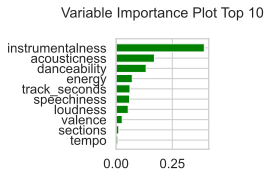

In [54]:
plot_variable_importance_top10(xgb2, X2_train, top_n=10)


REFITTING BASED ON DROPPED COLUMNS

In [58]:
X3_train = X2_train.drop(['tempo','speechiness','energy', 'sections'], axis = 1) #mode, key to be dropped here
X3_test = X2_test.drop(['tempo','speechiness','energy', 'sections'], axis = 1)
# rlr_secondf1 = plot_model(lr, lr_Xtrain, y2_train, X2_test, y2_test)


The base LR accuracy is: 0.75859
The base LR f1 is: 0.77776
The base LR precision is: 0.71892
The base LR recall is: 0.84923
Precision: 0.7264,   Recall: 0.8566, Accuracy: 0.7687
train error 0.8039882922469868 test error 0.7739686888193693
y pred proba  [1 1 0 ... 1 1 0]
Precision: 0.7126,   Recall: 0.8573, Accuracy: 0.7606, f1: 0.7783
AUC: 0.8394


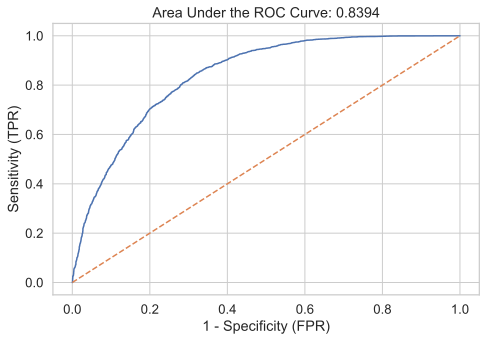

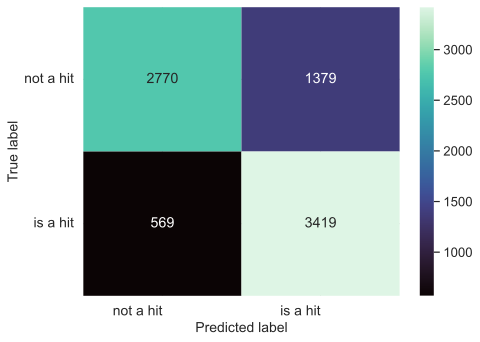

In [76]:
import pickle
plot_model(xgb2, X3_train, y2_train, X3_test, y2_test)
pickle.dump(xgb2, open('xgb_model.pkl', 'wb'))


The base LR accuracy is: 0.75913
The base LR f1 is: 0.77754
The base LR precision is: 0.71853
The base LR recall is: 0.84585
Precision: 0.7931,   Recall: 0.6343, Accuracy: 0.7363
train error 0.8037201022971804 test error 0.774581456896832
y pred proba  [1 1 0 ... 0 1 0]
Precision: 0.7886,   Recall: 0.6276, Accuracy: 0.7350, f1: 0.6990
AUC: 0.8386


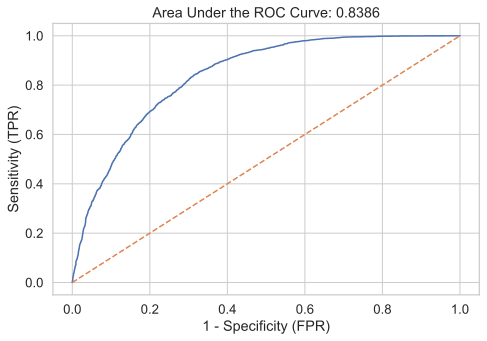

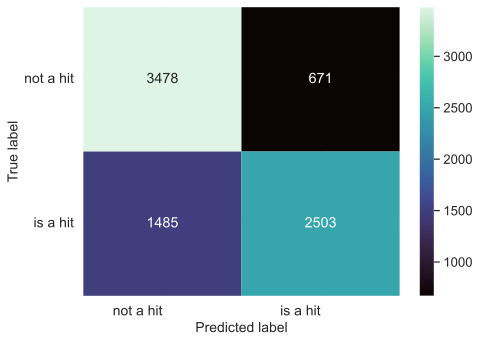

,y_pred_prob
0,0.694574
1,0.636142
2,0.149465
3,0.701321
4,0.366123
...,...
8132,0.473742
8133,0.806378
8134,0.659550
8135,0.776588


In [77]:
plot_model(xgb2, X3_train, y2_train, X3_test, y2_test, 0.66) # changing threshold to 0.66 for more precision

In [78]:
# Create DF for predicted prob/outcomes and merge back to orig df
y_pred_prob_df['row_num']= np.arange(len(y_pred_prob_df))

y_pred_df['row_num']= np.arange(len(y_pred_df))
X_test['row_num']= np.arange(len(X_test))
y_test_df = y_test.to_frame()
y_test_df['m_index'] = y_test_df.index
#y_test_df2=y_test_df.rename_axis('m_index')
y_test_df['row_num']= np.arange(len(y_test_df))


In [79]:
from functools import reduce
data_frames=[X_test,y_test_df,y_pred_df,y_pred_prob_df]
m_results = reduce(lambda left,right: pd.merge(left,right,on=['row_num'], how='outer'),data_frames)

In [80]:
m_results.head(10)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,chorus_hit,sections,track_seconds,row_num,target,m_index,y_pred,y_pred_prob
0,0.573,0.369,-8.965,0.0261,0.93900,0.000000,0.2850,0.612,88.250,4,40.04916,7,165.107,0,1,6024,1.0,0.694574
1,0.489,0.695,-5.551,0.0298,0.00323,0.000093,0.0879,0.228,114.952,4,82.62176,8,242.933,1,0,31675,0.0,0.636142
2,0.655,0.425,-12.599,0.2430,0.55200,0.201000,0.1420,0.819,166.637,4,18.32694,12,211.187,2,1,10045,0.0,0.149465
3,0.695,0.952,-5.815,0.0576,0.01780,0.044500,0.3610,0.702,112.164,4,61.82980,10,220.264,3,1,17386,1.0,0.701321
4,0.472,0.848,-6.266,0.1770,0.63000,0.126000,0.0833,0.788,137.929,4,56.63673,10,234.137,4,0,6585,0.0,0.366123
5,0.365,0.552,-6.083,0.0351,0.41400,0.000000,0.0608,0.596,144.319,4,35.67564,12,200.307,5,0,10109,0.0,0.054251
6,0.733,0.623,-9.997,0.2580,0.45900,0.033800,0.3140,0.608,83.683,4,46.51968,5,98.059,6,0,11557,0.0,0.602309
7,0.524,0.843,-7.002,0.0374,0.00729,0.030100,0.6900,0.284,117.078,4,72.60447,5,149.253,7,0,20075,1.0,0.822775
8,0.503,0.297,-16.374,0.0314,0.22900,0.001190,0.0831,0.356,124.965,4,42.56398,14,311.867,8,1,16186,1.0,0.861066
9,0.936,0.523,-6.710,0.0597,0.23900,0.000000,0.1170,0.699,119.889,4,77.54349,4,124.056,9,1,36519,0.0,0.594143


In [81]:
df['m_index'] = df.index
final_df = pd.merge(df,m_results,left_on='m_index',right_on='m_index')

In [82]:
final_df.head()

,danceability_x,energy_x,key,loudness_x,mode,speechiness_x,acousticness_x,instrumentalness_x,liveness_x,valence_x,...,valence_y,tempo_y,time_signature_y,chorus_hit_y,sections_y,track_seconds_y,row_num,target_y,y_pred,y_pred_prob
0,0.520,0.411,A,-12.411,major,0.0315,0.786,0.001200,0.1460,0.3500,...,0.3500,120.290,4,37.54527,9,207.573,3558,1,0.0,0.495920
1,0.521,0.396,F,-12.299,major,0.0463,0.576,0.000893,0.4620,0.5990,...,0.5990,82.628,4,48.36482,8,179.600,753,0,1.0,0.712396
2,0.147,0.246,C# / Db,-16.997,major,0.0504,0.964,0.115000,0.1130,0.0387,...,0.0387,74.940,4,76.04885,18,464.533,1892,0,0.0,0.545866
3,0.427,0.140,A,-19.857,minor,0.0340,0.549,0.000001,0.0443,0.2930,...,0.2930,137.787,4,70.51508,8,207.293,1513,0,0.0,0.007834
4,0.431,0.551,C# / Db,-12.732,major,0.0526,0.885,0.875000,0.1280,0.6400,...,0.6400,79.140,4,23.24725,13,219.240,5392,0,0.0,0.032219


In [83]:
final_df.to_csv(r'sb_final_df.csv', index = False)

In [84]:
hit_predict = xgb2.predict(X3_test) #not sure if X3_test is correct
hit_score = xgb2.predict_proba(X3_test) #not sure if X3_test is correct
print(f'prediction: {hit_predict[0]} \nprobability of yay: {hit_score[0][1]}\nprobability of nay: {hit_score[0][0]}')


prediction: 1 
probability of yay: 0.6945742336480016
probability of nay: 0.30542576635199836
